# Input Data: Towers, City Areas, CASEN Survey, Travel Survey

By: Eduardo Graells-Garrido (egraells@udd.cl)

In this notebook we prepare the basic input data for our project. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
#import smopy
import joblib

sns.set(context='poster', style='ticks', palette='Accent', font_scale=1.1)
%matplotlib inline

## Urban Areas

In [3]:
urban_areas = (gpd.read_file('../../datasets/shapefiles/urban_areas/', crs={'init': 'epsg:5361'})
               .to_crs({'init': 'epsg:4326'}))
urban_areas.sample(5)

,NOMBRE,TIPO_AREA,SHAPE_Leng,SHAPE_Area,geometry
262,Coinco,Pueblo,18611.702563,2.226378e+06,POLYGON ((-70.99080876180511 -34.3040065762596...
73,Achao,Pueblo,6878.493141,1.587466e+06,POLYGON ((-73.49975728610187 -42.4676540472772...
353,Machali,Ciudad,13497.743419,3.398234e+06,POLYGON ((-70.64154894301808 -34.1667781555991...
293,Cauquenes,Ciudad,17713.653537,5.576394e+06,POLYGON ((-72.31227758581905 -35.9925718638182...
292,Curico,Ciudad,24273.753138,1.524009e+07,POLYGON ((-71.18718180342951 -34.9643411724797...


In [4]:
urban_areas[urban_areas.NOMBRE == 'Santiago'].shape

(1, 5)

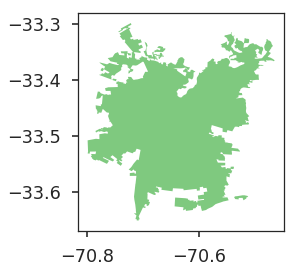

In [5]:
urban_areas[urban_areas.NOMBRE == 'Santiago'].plot()

## Santiago

In [6]:
municipalities = gpd.read_file('../../datasets/shapefiles/shapefile_comunas/division_comunal.shp', 
                              crs={'init': 'epsg:5361'})
municipalities.head()

,NOM_REG,NOM_PROV,NOM_COM,SHAPE_LENG,DIS_ELEC,CIR_SENA,COD_COMUNA,SHAPE_Le_1,SHAPE_Area,geometry
0,Región de La Araucanía,Malleco,Ercilla,170675.595438,48,14,9204,170675.595706,4.979025e+08,"POLYGON ((190393.2198999999 5794527.3661, 1904..."
1,Región de La Araucanía,Malleco,Lonquimay,346907.195437,49,14,9205,346907.195899,3.932854e+09,"POLYGON ((294265.5926999999 5781748.8701, 2943..."
2,Región de La Araucanía,Malleco,Los Sauces,169844.122286,48,14,9206,169844.122239,8.519730e+08,"POLYGON ((155495.1031999998 5804765.8096, 1555..."
3,Región de La Araucanía,Malleco,Lumaco,227705.219204,48,14,9207,227705.218806,1.112643e+09,"POLYGON ((159561.5301000001 5778741.6606, 1597..."
4,Región de La Araucanía,Malleco,Purén,137030.480474,48,14,9208,137030.480353,4.654760e+08,"POLYGON ((145272.5931000002 5804247.7066, 1453..."


In [7]:
municipalities['area_km2'] = municipalities.area / 1000000
municipalities = municipalities.to_crs({'init': 'epsg:4326'})

In [8]:
metropolitan_region = municipalities[municipalities.NOM_REG == 'Región Metropolitana de Santiago']
metropolitan_region.shape

(52, 11)

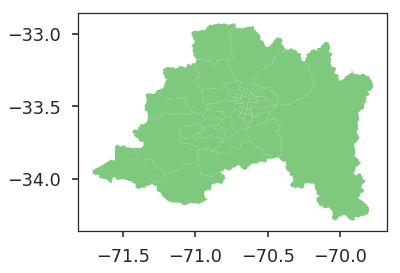

In [9]:
metropolitan_region.plot()

In [10]:
bbox = urban_areas[urban_areas.NOMBRE == 'Santiago'].envelope[385]

In [11]:
stgo_area = urban_areas[urban_areas.NOMBRE == 'Santiago'].geometry
stgo_area

385    (POLYGON ((-70.73662882538488 -33.371762170851...
Name: geometry, dtype: object

This is not the idiomatic way of doing it, but using geopandas' overlays has lower quality (and unstructured) results.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


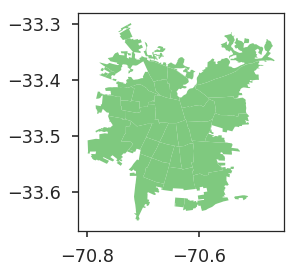

In [12]:
metropolitan_region['geometry'] = metropolitan_region.geometry.map(lambda x: x.intersection(stgo_area[385]))
urban_municipalities = metropolitan_region[metropolitan_region.area > 0].copy()
urban_municipalities.plot()

In [13]:
!mkdir intermediate

mkdir: cannot create directory 'intermediate': File exists


In [14]:
#urban_municipalities.to_file('./intermediate/urban_municipalities.shp')
joblib.dump(urban_municipalities, './intermediate/urban_municipalities.joblib.gz')

['./intermediate/urban_municipalities.joblib.gz']

## Cell Network Towers



This is the list of Telefónica antennas in the entire country. Note that a tower (BTS) has many antennas. We will work at the tower level.

In [15]:
!head -n 2 ../data/antennas_by_comuna.csv

,cdrid,description,lat,lon,height,azimuth,tower,geometry,index_right,comuna,id,province,region
0,ALDEF8X,Sargento Aldea,-33.53313333,-70.63531111,30.0,0.0,ALDEF,POINT (-70.63531111 -33.53313333),300,La Granja,13111,Santiago,Metropolitana de Santiago


In [16]:
antennas = (pd.read_csv('../data/antennas_by_comuna.csv', encoding='utf-8')
                .assign(tower=lambda x: x.cdrid.str.slice(0, 5))
                .rename(columns={'description': 'name', 'cdrid': 'antenna', 'comuna': 'municipality'})
                .sort_values('tower')
                .drop(['region', 'index_right', 'id', 'geometry'], axis=1)
                .dropna(subset=['name'])
                .drop_duplicates(subset=['tower'])
            )
antennas.head()

,Unnamed: 0,antenna,name,lat,lon,height,azimuth,tower,municipality,province
19528,34923,11NLIU2,11 Norte Libertad,-33.011667,-71.548722,27.0,250.0,11NLI,Vina del Mar,Valparaíso
23423,32326,11SEPL0,11 de Septiembre,-33.422272,-70.611108,10.0,220.0,11SEP,Providencia,Santiago
15015,35267,14COSU2,Ochagavia Cosite,-33.543100,-70.686000,33.0,120.0,14COS,El Bosque,Santiago
5054,20373,15COSU1,La Estrella Cosite,-33.442500,-70.758889,18.0,70.0,15COS,Pudahuel,Santiago
19609,38564,15NTFW8,15 Norte,-33.008853,-71.546814,30.0,110.0,15NTF,Vina del Mar,Valparaíso


In [17]:
antennas.shape

(3966, 10)

In [18]:
def to_point(row):
    return Point(row.lon, row.lat)

antennas.head().apply(to_point, axis=1)

19528          POINT (-71.548722 -33.011667)
23423          POINT (-70.611108 -33.422272)
15015    POINT (-70.68600000000001 -33.5431)
5054             POINT (-70.758889 -33.4425)
19609    POINT (-71.5468138889 -33.00885277)
dtype: object

In [19]:
antennas = gpd.GeoDataFrame(antennas, geometry=antennas.apply(to_point, axis=1),
                           crs={'init': 'epsg:4326'})
antennas.head()

,Unnamed: 0,antenna,name,lat,lon,height,azimuth,tower,municipality,province,geometry
19528,34923,11NLIU2,11 Norte Libertad,-33.011667,-71.548722,27.0,250.0,11NLI,Vina del Mar,Valparaíso,POINT (-71.548722 -33.011667)
23423,32326,11SEPL0,11 de Septiembre,-33.422272,-70.611108,10.0,220.0,11SEP,Providencia,Santiago,POINT (-70.611108 -33.422272)
15015,35267,14COSU2,Ochagavia Cosite,-33.543100,-70.686000,33.0,120.0,14COS,El Bosque,Santiago,POINT (-70.68600000000001 -33.5431)
5054,20373,15COSU1,La Estrella Cosite,-33.442500,-70.758889,18.0,70.0,15COS,Pudahuel,Santiago,POINT (-70.758889 -33.4425)
19609,38564,15NTFW8,15 Norte,-33.008853,-71.546814,30.0,110.0,15NTF,Vina del Mar,Valparaíso,POINT (-71.5468138889 -33.00885277)


In [20]:
antennas.shape

(3966, 11)

In [22]:
antennas_stgo = (gpd.tools.sjoin(antennas.drop(['municipality', 'province'], axis=1).reset_index(), 
                                 urban_municipalities.loc[:,('geometry','NOM_COM')], 
                                 how='inner', op='within')
                 .rename(columns={'NOM_COM': 'municipality'})
                 .loc[:,('tower', 'antenna', 'geometry', 'municipality', 'name')]
                 #.drop_duplicates(subset=['tower'], keep='first')
                )
antennas_stgo.sample(5)

,tower,antenna,geometry,municipality,name
642,CCY3A,CCY3AL0,POINT (-70.60588 -33.417957),Providencia,Mall Costanera Center Est.-3
3776,TSMAQ,TSMAQU9,POINT (-70.583889 -33.371667),Vitacura,Traslado Santa Maria de Manquehue
3178,REIG1,REIG1U2,POINT (-70.5527 -33.4468),La Reina,La Reina
39,ACA1E,ACA1EW1,POINT (-70.54533000000001 -33.39104),Las Condes,Mall Alto las Condes
2575,NLYON,NLYONU3,POINT (-70.612533 -33.421375),Providencia,Nueva de Lyon


In [23]:
antennas_stgo.shape

(1374, 5)

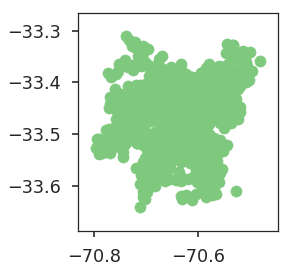

In [25]:
antennas_stgo.plot()

In [24]:
joblib.dump(antennas_stgo, './intermediate/urban_towers.joblib.gz')

['./intermediate/urban_towers.joblib.gz']